In [ ]:
import argparse
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
class FullyConvolutionalNetwork(torch.nn.Module):
    '''
    Fully convolutional network

    Args:
        Please add any necessary arguments
    '''

    def __init__(self):
        super(FullyConvolutionalNetwork, self).__init__()

        # TODO: Design your neural network using
        # (1) convolutional layers
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # (2) max pool layers
        # https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d
        # (3) average pool layers
        # https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.avg_pool2d
        # (4) transposed convolutional layers
        # https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.down1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.up1 = nn.ConvTranspose2d(64, 128, kernel_size = 3, padding = 1, stride = 2)
        self.conv4 = nn.Conv2d(144, 32, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(32, 3, kernel_size = 3, padding = 1)

    def forward(self, x):
        '''
            Args:
                x : torch.Tensor
                    tensor of N x d

            Returns:
                torch.Tensor
                    tensor of n_output
        '''

        # TODO: Implement forward function
        a = self.conv1(x)
        x = F.relu(a)
        x = self.down1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.up1(x)
        x = F.interpolate(x, size=(480, 640), mode='bilinear')
        x = torch.cat((a, x), 1)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        outputs = torch.sigmoid(x)
        
        return outputs

In [ ]:
def train(net,
          dataloader,
          n_epoch,
          optimizer,
          learning_rate_decay,
          learning_rate_decay_period):
    '''
    Trains the network using a learning rate scheduler

    Args:
        net : torch.nn.Module
            neural network
        dataloader : torch.utils.data.DataLoader
            # https://pytorch.org/docs/stable/data.html
            dataloader for training data
        n_epoch : int
            number of epochs to train
        optimizer : torch.optim
            https://pytorch.org/docs/stable/optim.html
            optimizer to use for updating weights
        learning_rate_decay : float
            rate of learning rate decay
        learning_rate_decay_period : int
            period to reduce learning rate based on decay e.g. every 2 epoch

        Please add any necessary arguments

    Returns:
        torch.nn.Module : trained network
    '''

    # TODO: Define loss function
    loss_func = torch.nn.MSELoss()
    start = time.time()
    for epoch in range(n_epoch):

        # Accumulate total loss for each epoch
        total_loss = 0.0

        # TODO: Decrease learning rate when learning rate decay period is met
        # e.g. decrease learning rate by a factor of decay rate every 2 epoch
        if epoch and epoch % learning_rate_decay_period == 0:

            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate_decay * param_group['lr']

        for batch, (clean_img, _) in enumerate(dataloader):
            # images
            noisy_img = torch.clamp(clean_img + 0.75*torch.randn(clean_img.shape), min=0, max=1)
            noisy_img = noisy_img.to(device)
            clean_img = clean_img.to(device)

            # TODO: Forward through the network
            outputs = net(noisy_img)

            # TODO: Clear gradients so we don't accumlate them from previous batches
            optimizer.zero_grad()

            # TODO: Compute loss function
            loss = loss_func(outputs, clean_img)

            # TODO: Update parameters by backpropagation
            loss.backward()
            optimizer.step()

            # TODO: Accumulate total loss for the epoch
            total_loss = total_loss + loss.item()
            

        mean_loss = total_loss / float(batch)
        end = time.time() - start
        # Log average loss over the epoch
        print('Epoch=%d  Loss: %.3f   Time: %d' % (epoch + 1, mean_loss, end))

    return net

In [ ]:
def evaluate(net, dataloader):
    '''
    Evaluates the network on a dataset

    Args:
        net : torch.nn.Module
            neural network
        dataloader : torch.utils.data.DataLoader
            # https://pytorch.org/docs/stable/data.html
            dataloader for tresting data

        Please add any necessary arguments
    '''
    PSNR = []
    MSE = []

    # Make sure we do not backpropagate
    with torch.no_grad():

        for (clean_img, _) in dataloader:

            # TODO: Forward through the network
            noisy_img = torch.clamp(clean_img + 0.75*torch.randn(clean_img.shape), min=0, max=1)
            noisy_img = noisy_img.to(device)
            clean_img = clean_img.to(device)

            outputs = net(noisy_img)

            # TODO: Compute evaluation metric(s) for each sample (PSNR, MSE)
            psnr = peak_signal_to_noise_ratio(outputs, clean_img)
            PSNR.append(psnr)

            mse = mean_squared_error(outputs, clean_img)
            MSE.append(mse)
            

    # TODO: Compute mean evaluation metric(s)
    mean_psnr = sum(PSNR) / len(PSNR)
    mean_mse = sum(MSE) / len(MSE)

    # TODO: Print scores
    print('Mean PSNR: %.3f' % mean_psnr)
    print('Mean MSE: %.3f' % mean_mse)

    # TODO: Convert the last batch of images back to original shape
    tensor2img = torchvision.transforms.ToPILImage()

    labels = ['noisy', 'reconstructed', 'clean']
    
    for i in range(len(outputs)):
        images = [torch.squeeze(noisy_img[i].cpu()), 
                  torch.squeeze(outputs[i].cpu()), 
                  torch.squeeze(clean_img[i].cpu())]
        fig = plt.figure()
        for img in range(0,len(images)):
            a = fig.add_subplot(1,len(images),img+1)
            plt.imshow(tensor2img(images[img]))
            a.set_xticks([])
            a.set_yticks([])
            subtitle = labels[img]
            a.set(xlabel=subtitle)

In [ ]:
def peak_signal_to_noise_ratio(prediction, ground_truth):
    '''
    Computes the peak signal to noise ratio (PSNR) between prediction and ground truth

    Args:
        prediction : numpy
            N x h x w prediction
        ground_truth : numpy
            N x h x w ground truth

    Returns:
        float : peak signal to noise ratio
    '''

    # TODO: Computes peak signal to noise ratio
    # Implement ONLY if you are working on image reconstruction or denoising
    mse = torch.mean((prediction - ground_truth) ** 2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))

    return psnr

def mean_squared_error(prediction, ground_truth):
    '''
    Computes the mean squared error (MSE) between prediction and ground truth

    Args:
        prediction : numpy
            N x h x w prediction
        ground_truth : numpy
            N x h x w ground truth

    Returns:
        float : mean squared error
    '''

    # TODO: Computes mean squared error
    # Implement ONLY if you are working on image reconstruction or denoising
    mse = torch.mean((prediction - ground_truth) ** 2)

    return mse

In [ ]:
# hyperparameters

train_network = True
bs = 8
n_epoch = 5
lr = 0.5
lr_decay = 0.9
lr_decay_period = 1.0
momentum = 0.8
lambda_weight_decay = None
device = torch.device("cuda")

In [ ]:
if __name__ == '__main__':

    # TODO: Set up data preprocessing step
    data_preprocess_transform = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Resize(size=(480,640))
                                ])
    
    train_data = torchvision.datasets.VOCSegmentation(
        root='./data',
        image_set='train',
        download=True,
        transform=data_preprocess_transform,
        target_transform=data_preprocess_transform)

    val_data = torchvision.datasets.VOCSegmentation(
        root='./data',
        image_set='val',
        download=True,
        transform=data_preprocess_transform,
        target_transform=data_preprocess_transform)

    # Setup a dataloader (iterator) to fetch from the training set
    dataloader_train = torch.utils.data.DataLoader(
        train_data,
        batch_size=bs,
        shuffle=True,
        num_workers=0)

    # Setup a dataloader (iterator) to fetch from the testing set
    dataloader_test = torch.utils.data.DataLoader(
        val_data,
        batch_size=bs,
        shuffle=False,
        num_workers=0)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch=1  Loss: 0.029   Time: 220
Epoch=2  Loss: 0.011   Time: 438
Epoch=3  Loss: 0.010   Time: 669
Epoch=4  Loss: 0.010   Time: 901
Epoch=5  Loss: 0.009   Time: 1133
Mean PSNR: 20.400
Mean MSE: 0.009


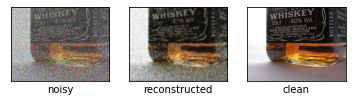

In [ ]:
    # TODO: Define network
    net = FullyConvolutionalNetwork()
    net.to(device)

    # TODO: Setup learning rate optimizer
    # https://pytorch.org/docs/stable/optim.html?#torch.optim.SGD
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr = lr,
        #weight_decay = lambda_weight_decay,
        momentum = momentum)
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size = lr_decay_period,
        gamma = lr_decay)

    if train_network:
        # Set network to training mode
        net.train()

        # TODO: Train network and save into checkpoint
        net = train(net=net, 
                    dataloader=dataloader_train, 
                    n_epoch=n_epoch, 
                    optimizer=optimizer, 
                    learning_rate_decay=lr_decay, 
                    learning_rate_decay_period=lr_decay_period)
        
        torch.save({'state_dict':net.state_dict()}, './checkpoint.pth')

        # Saves weight to checkpoint
        torch.save({ 'state_dict' : net.state_dict()}, './checkpoint.pth')
    else:
        # Load network from checkpoint
        checkpoint = torch.load('./checkpoint.pth')
        net.load_state_dict(checkpoint['state_dict'])

    # Set network to evaluation mode
    net.eval()

    # TODO: Evaluate network on testing set
    evaluate(net, dataloader_test)